In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;</style>"))
import os 
os.chdir("..")
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from numerics.integration.matrices import *
from numerics.utilities.misc import *
import tensorflow as tf
from numerics.machine_learning.models import * 
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


/tmp/ipykernel_4738/2984223652.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
params, exp_path = def_params()
total_time = 2000.
dt = 1e-1
states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

In [62]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 1#len(tfsignals[0])
batch_shape = [BS, None, 3]
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=tuple([None,None,3]))#tuple(batch_shape))
model.recurrent_layer.build(tf.TensorShape(batch_shape))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [63]:
spp = tf.split(tfsignals, 1000, axis=1)

In [64]:
n_epochs = 100

In [65]:
cc = []
for epoch in range(n_epochs):
    model.reset_states()  
    for k in spp:
        bb = model.train_step((k,k))
        cc+=[bb]
    print("\r EPOCH {}/{}   loss:{}    params{}    grads{}".format(epoch, n_epochs,loss, np.squeeze(bb["PARAMS"].numpy()), np.squeeze(bb["GRADS"].numpy())),end="")

 EPOCH 22/100   loss:0.0    params[9.999993   0.62831855]    grads[0. 0.]]    grads[-1.06367725e-05  0.00000000e+00]

KeyboardInterrupt: 

[]

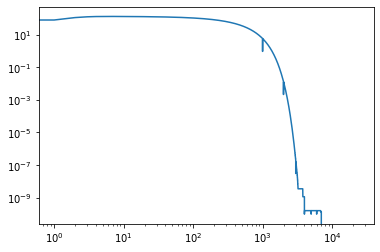

In [68]:
plt.plot(np.squeeze([cc[k]["LOSS"] for k in range(len(cc))]))
plt.loglog()

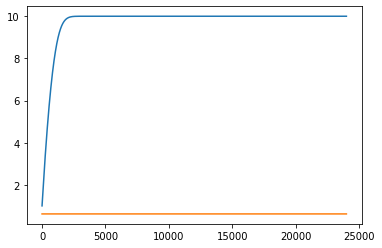

In [67]:
plt.plot(np.squeeze([cc[k]["PARAMS"] for k in range(len(cc))]))